In [1]:
from os import getcwd, listdir
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATASET = getcwd() + "/dataset/rps-cv-images/"
CLASSES = 3
IMG_WIDTH = 300
IMG_HEIGHT = 200
BATCH_SIZE = 16
NB_TRAIN_SAMPLES = 1751
NB_VALIDATION_SAMPLES = 437
EPOCHS = 50

In [3]:
DATASET

'/home/amogh/Documents/Study/PiRockPaperScissors/notebooks/dataset/rps-cv-images/'

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATASET,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
)

validation_generator = test_datagen.flow_from_directory(
    DATASET,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [5]:
model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(CLASSES, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 99, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 97, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 46, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 209024)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

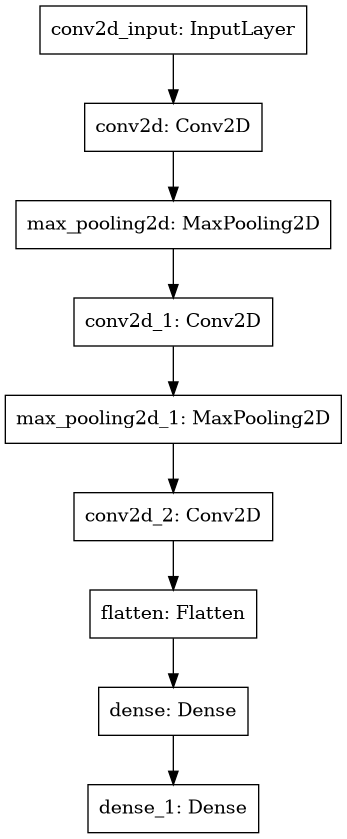

In [6]:
plot_model(model)

In [7]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True
)

callbacks = [earlystop]

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE,
)

Epoch 1/50
109/109 [==============================] - 19s 173ms/step - loss: 1.0308 - accuracy: 0.5948 - val_loss: 0.6890 - val_accuracy: 0.7593
Epoch 2/50
109/109 [==============================] - 17s 159ms/step - loss: 0.4613 - accuracy: 0.8225 - val_loss: 0.3221 - val_accuracy: 0.8889
Epoch 3/50
109/109 [==============================] - 17s 157ms/step - loss: 0.3131 - accuracy: 0.8807 - val_loss: 0.2772 - val_accuracy: 0.9051
Epoch 4/50
109/109 [==============================] - 17s 156ms/step - loss: 0.2557 - accuracy: 0.9118 - val_loss: 0.2102 - val_accuracy: 0.9398
Epoch 5/50
109/109 [==============================] - 17s 155ms/step - loss: 0.2179 - accuracy: 0.9170 - val_loss: 0.2233 - val_accuracy: 0.9306
Epoch 6/50
109/109 [==============================] - 17s 154ms/step - loss: 0.2050 - accuracy: 0.9262 - val_loss: 0.2498 - val_accuracy: 0.9051
Epoch 7/50
109/109 [==============================] - 17s 154ms/step - loss: 0.1545 - accuracy: 0.9441 - val_loss: 0.1428 - val_ac

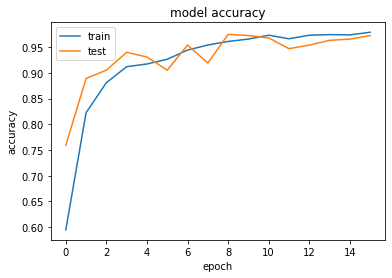

In [8]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

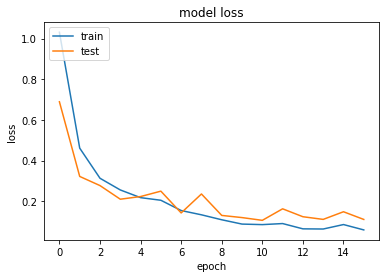

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [10]:
model.save("rps-cnn.h5")

In [11]:
model.save_weights("rps-cnn-weights.h5")

In [13]:
loaded_model = load_model(getcwd() + "/rps-cnn.h5")

In [38]:
Y_pred = loaded_model.predict_generator(
    validation_generator, NB_VALIDATION_SAMPLES // BATCH_SIZE + 1
)
y_pred = np.argmax(Y_pred, axis=1)

class_labels = {v: k for k, v in validation_generator.class_indices.items()}

print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred))

print("Classification Report")
target_names = list(class_labels.values())
print(
    classification_report(
        validation_generator.classes, y_pred, target_names=target_names
    )
)

Confusion Matrix
[[133   5   4]
 [  1 144   0]
 [  3   1 146]]
Classification Report
              precision    recall  f1-score   support

       paper       0.97      0.94      0.95       142
        rock       0.96      0.99      0.98       145
    scissors       0.97      0.97      0.97       150

    accuracy                           0.97       437
   macro avg       0.97      0.97      0.97       437
weighted avg       0.97      0.97      0.97       437



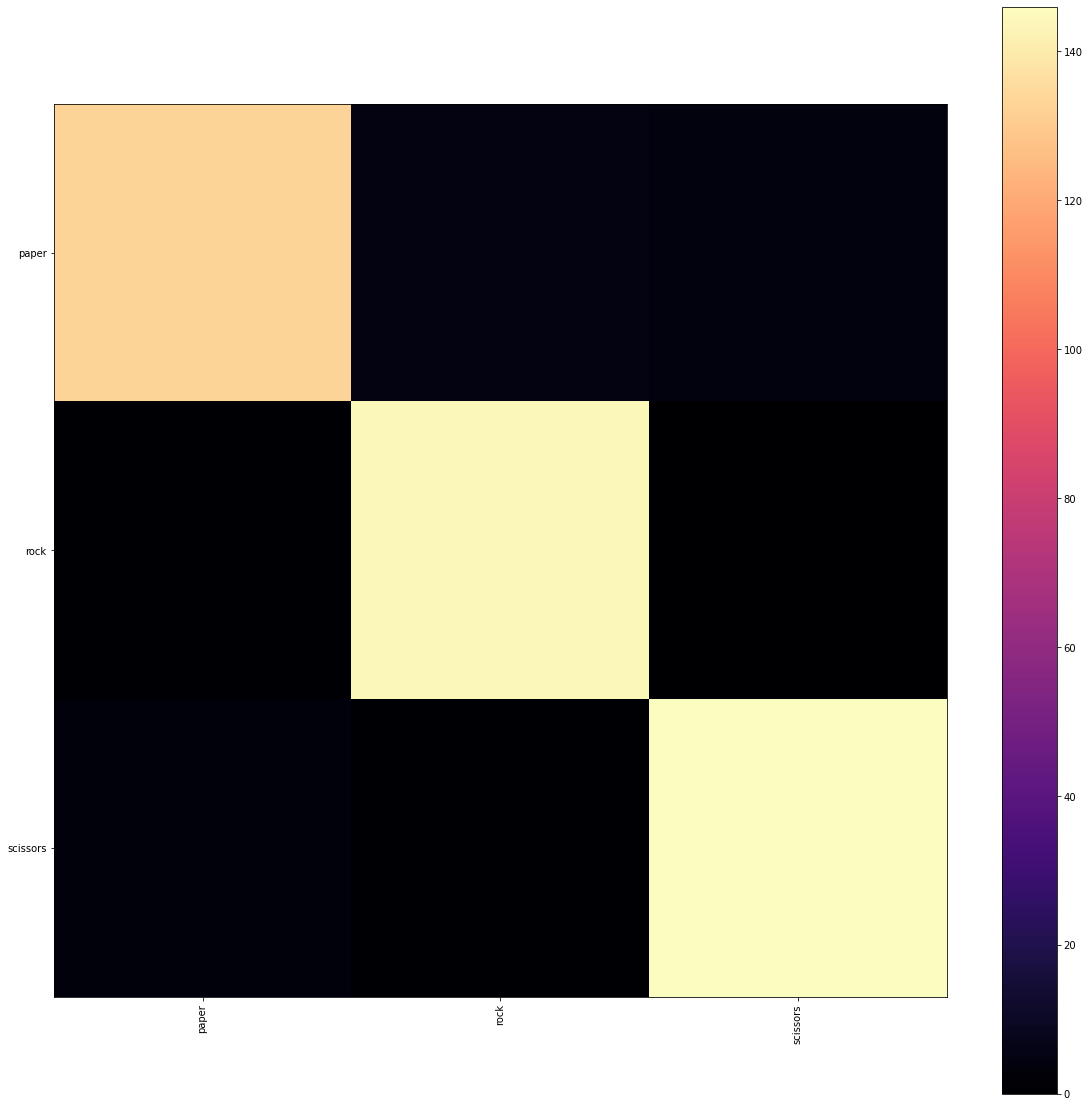

In [39]:
plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
plt.imshow(cnf_matrix, interpolation='nearest', cmap = "magma")
plt.colorbar()

classes = list(class_labels.values())

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

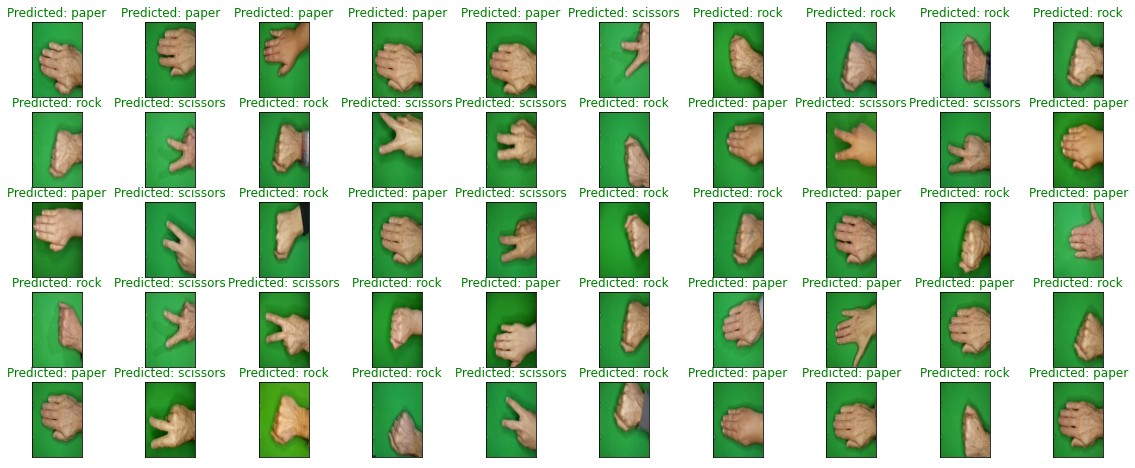

In [36]:
path = DATASET

fig = plt.figure(figsize=(20, 8))


def predictedLabelColor(original, predicted):
    if original == predicted:
        return "green"
    else:
        return "red"


for i in range(50):
    rps_names = listdir(path)
    rps_names_folders = listdir(path)
    random_rps_index = np.random.randint(0, len(rps_names))
    rps_name = rps_names_folders[random_rps_index]

    rps_images_path = path + "/" + rps_name
    rps_images = listdir(rps_images_path)
    random_rps_image_index = np.random.randint(0, len(rps_images))
    rps_image = rps_images[random_rps_image_index]
    rps_image_path = rps_images_path + "/" + rps_image

    result_image_array = image.img_to_array(
        image.load_img(rps_image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    )
    normalized_result = result_image_array * 1.0 / 255
    expanded_result = np.expand_dims(normalized_result, axis=0)
    classes = loaded_model.predict_classes(expanded_result, batch_size=10)
    predicted_label = class_labels[classes[0]]

    ax = fig.add_subplot(5, 10, 1 + i, xticks=[], yticks=[])
    ax.set_title(
        "Predicted: {}".format(predicted_label),
        color=predictedLabelColor(rps_name, predicted_label),
    )
    plt.imshow(normalized_result)

plt.show()